In [2]:
# import numpy as np
# dataset = "NYCTaxi"
# data_path = fr"E:\estudy\ST-SSL\code\ST-SSL\data\{dataset}\train.npz"
# x_train = np.load(data_path)["x"]
# y_train = np.load(data_path)["y"]
# extreme_values_binary_tensor = np.load(data_path)["evs_90"]
# print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, evs.shape: {extreme_values_binary_tensor.shape}")
# Indices of nodes with the highest demand: [ 45  86  66  67  65  87  44 108  46  64 107  24  43  23  42  68  63 109
#  129 128]

x_train shape: (1912, 35, 200, 2), y_train shape: (1912, 1, 200, 2), evs.shape: (1912, 1, 200, 2)


## plotting evs from the learnt classifier

In [35]:
import matplotlib.pyplot as plt

# Set font family to Times New Roman and font sizes
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 17.5    # For main text in figures
plt.rcParams['axes.titlesize'] = 17.5  # Title of the axes
plt.rcParams['axes.labelsize'] = 17.5  # Label of the axes
plt.rcParams['xtick.labelsize'] = 17.5  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 17.5  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 17.5  # Legend font size

# Set default text color to black
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'


In [2]:


import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [4]:
import time
import yaml

# Define your configurations directly
configs = {
    'config_filename': 'configs/NYCTaxi.yaml',
    'S_Loss': 0,
    'T_Loss': 0,
    'seed': 1,
    'comment': "testing",
    'cheb_order': 3,
    'graph_init': "8_neighbours",
    'self_attention_flag': True,
    'cross_attention_flag': False,
    'feedforward_flag': False,
    'layer_norm_flag': False,
    'additional_sa_flag': False,
    'learnable_flag': False,
    'rank': 0,
    'pos_emb_flag': False,
    'add_8': True,
    'add_eye': False,
    'add_x_encoder': False,
    'freeze_encoder': False,
    'ipe': 1,
    "mode": "test"
}

# Optionally print the starting experiment configurations
print(f"Starting experiment with configurations in {configs['config_filename']}...")

# Simulate a brief pause
time.sleep(3)

# Load configurations from a file (if necessary, or you could just use the dictionary as is)
with open(configs['config_filename'], 'r') as file:
    file_configs = yaml.load(file, Loader=yaml.FullLoader)
    configs.update(file_configs)

# You can add logic to modify configurations based on your conditions here
experiment_name = "pred_"
if configs['S_Loss'] == 1:
    experiment_name += "+S"
if configs['T_Loss'] == 1:
    experiment_name += "+T"
experiment_name += f"_seed={configs['seed']}"

configs['comment'] = "noComment"
configs['ipe'] = 1000
configs['loss'] = "mae"
configs['threshold_adj_mx'] = False
configs['affinity_conv'] = False
configs["experimentName"] = experiment_name
configs["mode"] = "test"
configs["load_path"] = None

# Print the final configuration to start the experiment
print(f"Starting experiment with configurations {configs}...")
args = argparse.Namespace(**configs)

Starting experiment with configurations in configs/NYCTaxi.yaml...
Starting experiment with configurations {'config_filename': 'configs/NYCTaxi.yaml', 'S_Loss': 0, 'T_Loss': 0, 'seed': 1, 'comment': 'noComment', 'cheb_order': 3, 'graph_init': '8_neighbours', 'self_attention_flag': True, 'cross_attention_flag': False, 'feedforward_flag': False, 'layer_norm_flag': False, 'additional_sa_flag': False, 'learnable_flag': False, 'rank': 0, 'pos_emb_flag': False, 'add_8': True, 'add_eye': False, 'add_x_encoder': False, 'freeze_encoder': False, 'ipe': 1000, 'mode': 'test', 'device': 'cuda', 'best_path': 'None', 'debug': False, 'data_dir': 'data', 'dataset': 'NYCTaxi', 'input_length': 17, 'batch_size': 32, 'test_batch_size': 32, 'graph_file': 'data/NYCTaxi/adj_mx.npz', 'num_nodes': 200, 'row': 20, 'col': 10, 'd_input': 2, 'd_output': 2, 'd_model': 64, 'dropout': 0.1, 'percent': 0.1, 'shm_temp': 0.5, 'nmb_prototype': 4, 'yita': 0.5, 'start_epoch': 0, 'num_epochs': 1000, 'epochs': 1000, 'lr_init':

In [3]:
torch.cuda.is_available()

True

In [5]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cpu'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
    scalar_type='Standard'
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer
model = STSSL(args).to(args.device)

args.best_path = r'D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=3\20240822-122317\common backbone ablation\best_model_pred.pth'
state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )
msg = model.load_state_dict(state_dict['model'])
print("Load saved model msg: ", msg)

model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)

not indexing
using 90percent evs
not indexing
using 90percent evs
not indexing
using 90percent evs


!!Scaling is NOT off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is True!!


in else
in else
Load saved model msg:  <All keys matched successfully>


In [5]:
# ## start training
# trainer = Trainer(
#     model=model, 
#     optimizer=optimizer, 
#     dataloader=dataloader,
#     graph=graph, 
#     args=args
# )

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, args):
    model.eval()
    evs_true = []
    evs_pred = []
    y_pred = []
    y_true = []
    bias_pred = []
    o_tilde = []
    with torch.no_grad():
        prev_len = 0
        for phase in ["test"]:
            for batch_idx, (data, target, evs, _) in enumerate(dataloader[phase]):
                repr1, _ = model(data, graph)                
                pred_output = model.predict(repr1, evs, phase="bias")
                og_predicted = model.predict_o_tilde(repr1)
                # evs_predicted = model.get_evs(repr1_cls)
                bias = model.get_bias(repr1)
                y_true.append(target)
                y_pred.append(pred_output)
                evs_true.append(evs)
                evs_pred.append(evs)
                bias_pred.append(bias)
                o_tilde.append(og_predicted)
            print(f"Finished {phase} phase, with samples: {len(torch.cat(y_true, dim=0))-prev_len}")
            prev_len = len(torch.cat(y_true, dim=0))

    # y_true = torch.cat(y_true, dim=0).cpu().numpy()
    # y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    evs_true = torch.cat(evs_true, dim=0).cpu().numpy()
    evs_pred = torch.cat(evs_pred, dim=0).cpu().numpy()
    bias = scaler.inverse_transform(torch.cat(bias_pred, dim=0)).cpu().numpy()
    bias_scaled = bias * evs_true
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    o_tilde = scaler.inverse_transform(torch.cat(o_tilde, dim=0)).cpu().numpy()
    # bias_pred = scaler.inverse_transform(torch.cat(bias_pred, dim=0)).cpu().numpy()
    mask = np.where(y_true > (5), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    print("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)
    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    print("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0), y_true, y_pred, evs_true, evs_pred, bias, bias_scaled, o_tilde


In [9]:
_, y_true, y_pred, evs_true, evs_pred, bias, bias_scaled, o_tilde = test(model, dataloader, dataloader['scaler'], graph, args)

Finished test phase, with samples: 546
test, MAE: 11.54, test MAPE: 15.6820%
y_true.shape:  (546, 1, 200, 2) y_pred.shape:  (546, 1, 200, 2)
OUTFLOW, MAE: 9.51, MAPE: 16.4227%


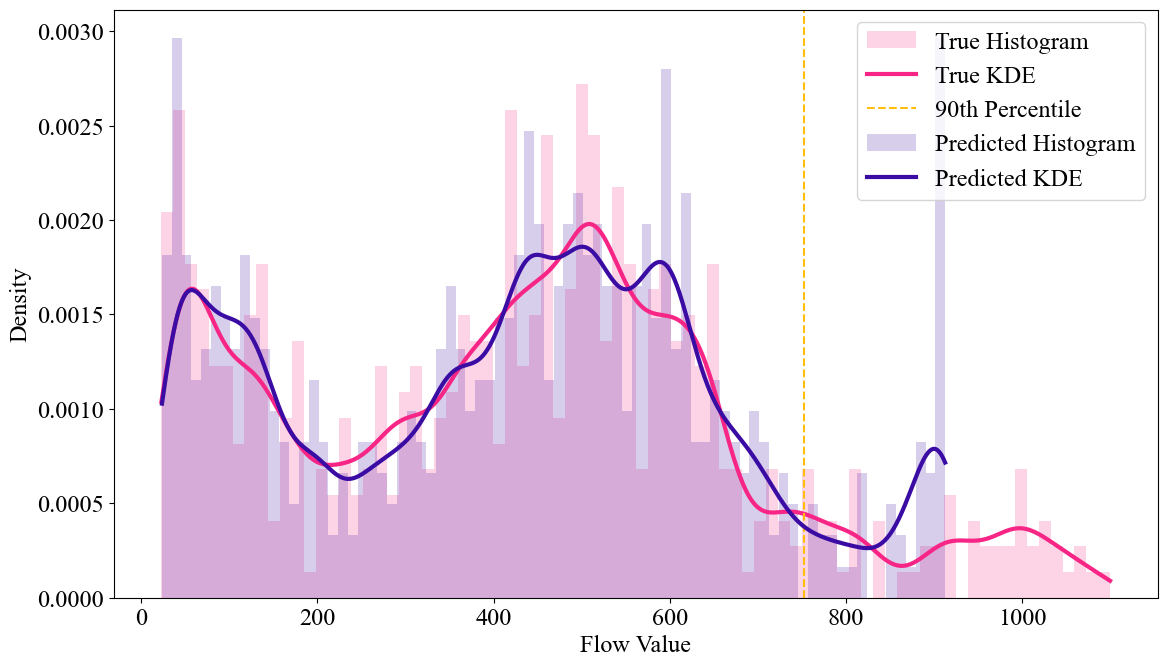

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming y_true, y_pred, and o_tilde are already defined as numpy arrays
# List of arrays with their corresponding labels and colors for plotting
data = [
    (y_true, 'True', '#f72585'),
    (y_pred, 'Predicted', '#3a0ca3'),
]
plt.figure(figsize=(12, 7))  # Adjust the size as needed

# Iterate over the list and plot each on the same figure
for array, label, color in data:
    # Extract the specific slice and filter the values
    a = array[:, 0, 86, 0]
    a = a[a > 5]
    
    # Calculate the 90th percentile for the current dataset
    percentile_90 = np.percentile(a, 90)

    # Plot the histogram of variable 'a' on the first subplot
    plt.hist(a, bins=80, density=True, alpha=0.2, color=color, label=f'{label} Histogram')

    # Generate the KDE (Kernel Density Estimate)
    kde = gaussian_kde(a, bw_method=0.1)  # Adjust bandwidth with bw_method
    x_range = np.linspace(a.min(), a.max(), 1000)

    # Plot the KDE curve for the current dataset
    plt.plot(x_range, kde(x_range), color=color, label=f'{label} KDE', lw=3, alpha=1)

    # If the label is 'True', plot the vertical line at the 90th percentile
    if label == 'True':
        plt.axvline(x=percentile_90, color="#ffbe0b", linestyle='--', label=f'90th Percentile')

# Add labels, title, and legend for the histogram/KDE plot
plt.xlabel('Flow Value')
plt.ylabel('Density')
plt.legend()

# Display the plots
plt.tight_layout()

plt.savefig('KDEPlots.png', dpi=500, bbox_inches='tight')
plt.show()


(2690, 1, 200, 2)
masked_y_true.shape:  (801, 1, 200) masked_y_pred.shape:  (801, 1, 200)


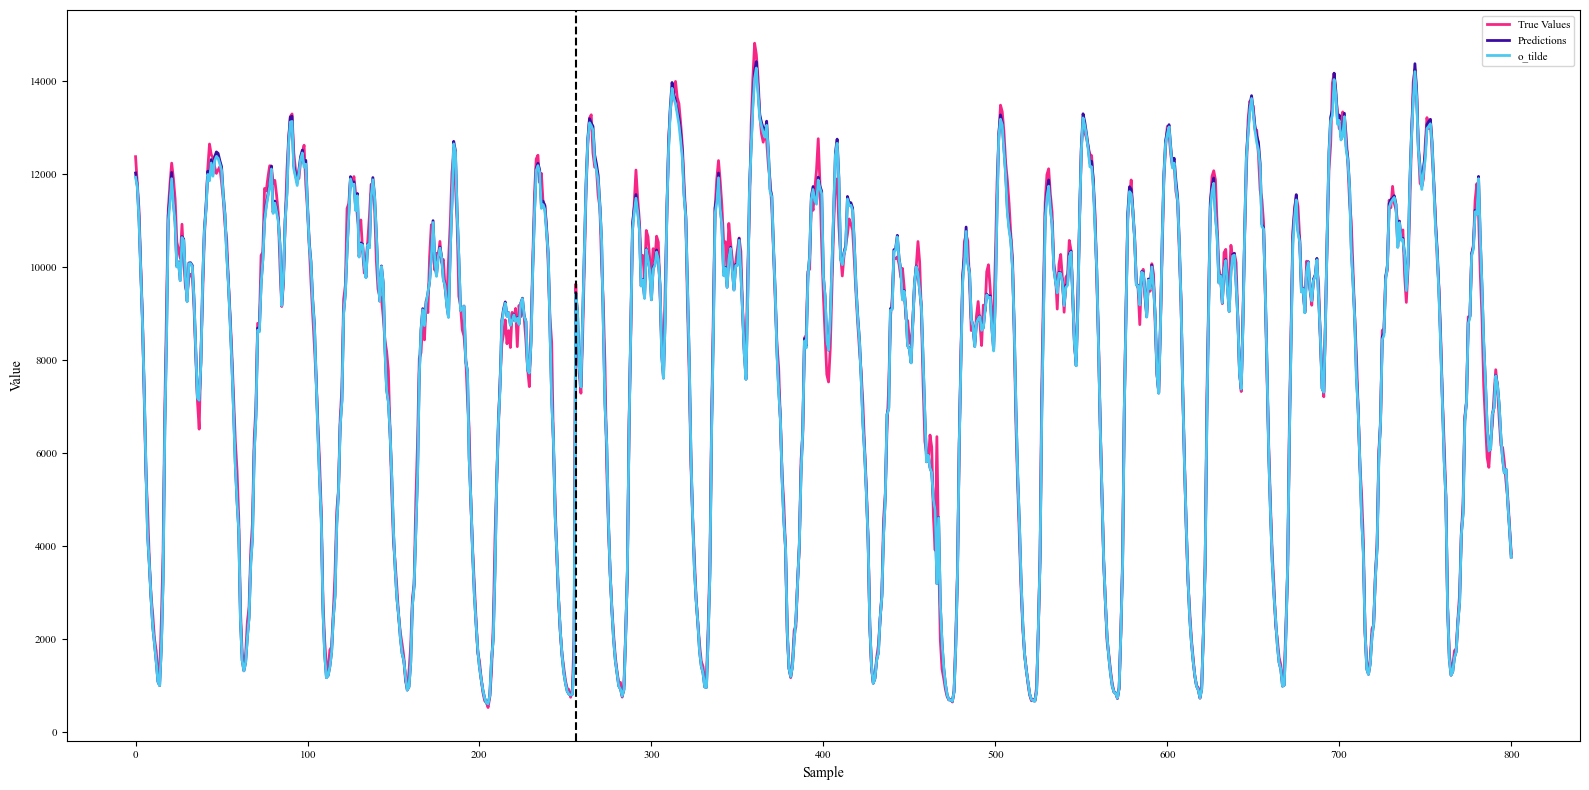

In [48]:
print(y_true.shape)
_y_true, _y_pred, _o_tilde = y_true, y_pred, o_tilde
# _y_true, _y_pred, _o_tilde = _y_true[:, :, :, 0], _y_pred[:, :, :, 0], _o_tilde[:, :, :, 0]
_y_true, _y_pred, _o_tilde = _y_true[1888:-1, :, :, 0], _y_pred[1888:-1, :, :, 0], _o_tilde[1888:-1, :, :, 0]
mask = _y_true > 5
# Apply the mask to y_true and y_pred to filter values
masked_y_true = np.where(mask, _y_true, np.nan)  # Replace unmasked values with NaN
masked_y_pred = np.where(mask, _y_pred, np.nan)  # Same for y_pred
masked_o_tilde = np.where(mask, _o_tilde, np.nan)  # Same for y_pred
print("masked_y_true.shape: ", masked_y_true.shape, "masked_y_pred.shape: ", masked_y_pred.shape)
# Sum and flatten the masked values for plotting
# Using np.nansum to ignore NaN values in summation
summed_masked_y_true = np.nansum(masked_y_true, axis=2).flatten()
summed_masked_y_pred = np.nansum(masked_y_pred, axis=2).flatten()
summed_masked_o_tilde = np.nansum(masked_o_tilde, axis=2).flatten()
# Set figure size for better resolution
plt.figure(figsize=(16, 8))  # Adjust the size as needed

# Plot with adjusted colors, linewidths, and linestyles
plt.plot(summed_masked_y_true, label='True Values', color="#f72585", linewidth=2, linestyle='-', alpha=1)
plt.plot(summed_masked_y_pred, label='Predictions', color='#3a0ca3', linewidth=2, linestyle='-', alpha=1)
plt.plot(summed_masked_o_tilde, label='o_tilde', color='#4cc9f0', linewidth=2, linestyle='-', alpha=1)

# Plot vertical lines at 1888 and 1888+256
# plt.axvline(x=1888, color='black', linestyle='--')
# plt.axvline(x=1888+256, color='black', linestyle='--')
plt.axvline(x=256, color='#000000', linestyle='--')
# Labels
# Set faint grid lines
# plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
# Set the font size and weight for the axis labels

plt.xlabel("Sample")
plt.ylabel("Value")

# Move legend outside the plot
legend = plt.legend(loc='best')

# Set the font size and weight for the axis labels

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(20, 55))

s, e = 150, 350
node_indices = [59, 51, 72, 50, 28, 41, 42, 49, 58, 43, 67, 33, 27, 44, 19, 34, 66, 35, 26, 52]
# node_indices = [i for i in range(25, 50)]
for i, node_index in enumerate(node_indices):
    inflow = y_true[s:e, 0, node_index, 0]
    inflow_pred = y_pred[s:e, 0, node_index, 0]
    inflow_o_tilde = o_tilde[s:e, 0, node_index, 0]
    inflow_bias = bias[s:e, 0, node_index, 0]
    inflow_bias_scaled = bias_scaled[s:e, 0, node_index, 0]

    inflow_evs = evs_pred[s:e, 0, node_index, 0]
    extreme_inflow_indicator = evs_pred[s:e, 0, node_index, 0]
    extreme_inflow_indicator_true = evs_true[s:e, 0, node_index, 0]
    
    extreme_inflow_indices = np.where(extreme_inflow_indicator >= .5)[0]
    extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]

    # Plotting inflow
    ax1 = plt.subplot(len(node_indices), 1, i + 1)
    ax1.plot(inflow, label='Inflow')
    ax1.plot(inflow_pred, label='Inflow_pred')
    ax1.plot(inflow_o_tilde, label='o_tilde')
    ax1.plot(inflow_bias, label='bias')
    ax1.plot(inflow_bias_scaled, label='bias_scaled')
    # ax1.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
    # ax1.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow _ pred', marker='x')
    
    ax1.set_title(f'Node {node_index}')
    ax1.set_xlabel('Time (sample index)')
    ax1.set_ylabel('Flow')

    # Create a second y-axis for the extreme value scale
    ax2 = ax1.twinx()
    ax2.plot(inflow_evs, label='evs indicator', color='purple', linestyle='--')
    ax2.set_ylabel('EVS (0-1 scale)', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')

    # Adding legend separately for clarity
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


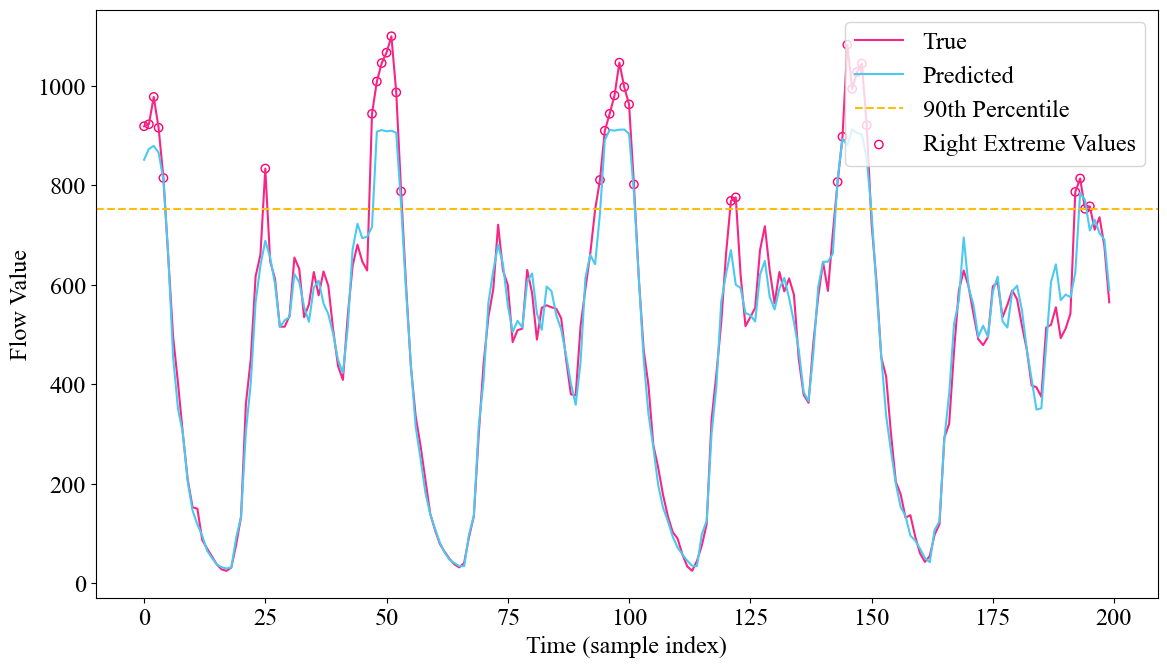

In [37]:
## plot from the newly defined binary tensor

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train and extreme_indicator_tensor are defined with the same shape
# and extreme_indicator_tensor contains 1 where there's an extreme event and 0 otherwise

# Set up the plot
plt.figure(figsize=(12, 7))

# Plotting for the first node (as the loop range is 1, it plots only the first node)
for node_index in range(1):
    s, e = 250, 450
    node_index=86
    inflow = y_true[:, 0, node_index, 0]
    percentile_90 = np.percentile(inflow, 90)
    inflow = y_true[s:e, 0, node_index, 0]
    inflow_pred = o_tilde[s:e, 0, node_index, 0]
    # inflow_pred_bias = y_pred[50:250, 0, node_index, 0]
    # outflow = y_train[:, 0, node_index, 1]
    
    # Plot a horizontal line at the 90th percentile
    
    # Extract extreme indicators for inflow and outflow
    # extreme_inflow_indicator = evs_pred[0:500, 0, node_index, 0]
    extreme_inflow_indicator_true = evs_true[s:e, 0, node_index, 0]
    # print("extreme_inflow_indicator", extreme_inflow_indicator)
    # extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
    # Identify indices where extreme events occur
    # extreme_inflow_indices = np.where(extreme_inflow_indicator >= .2)[0]
    extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]
    # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

    # data = [
    # (y_true, 'True Values', '#f72585'),
    # (y_pred, 'Predicted Values', '#3a0ca3'),
    # (o_tilde, 'o_tilde', '#4cc9f0')
    # ]
    # Plotting inflow and outflow
    # plt.subplot(1, 1, node_index + 1)
    plt.plot(inflow, label='True', color='#f72585')
    plt.plot(inflow_pred, label='Predicted', color='#4cc9f0')
    # plt.plot(inflow_pred_bias, label='Inflow_predicted', color='#3a0ca3')
    # plt.plot(outflow, label='Outflow')
    plt.axhline(y=percentile_90, color='#ffbe0b', linestyle='--', label='90th Percentile')

    # Marking the extreme events
    # plt.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
    # plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='#ff006e', label='Extreme Inflow _ pred', marker='o')
    # Marking the extreme events with hollow markers
    plt.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='#ff006e', label='Right Extreme Values', marker='o', facecolors='none', edgecolors='#ff006e')
    # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')
    # plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
    # Set the font size and weight for the axis labels
    
    plt.xlabel("Time (sample index)")
    plt.ylabel("Flow Value")
    # Set the border color of the plot

    # Move legend outside the plot
    legend = plt.legend(loc='best')
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.legend()

plt.tight_layout()

plt.savefig('NYCTaxi_Node1_EVS.png', dpi=500, bbox_inches='tight')
plt.show()
